Colaboratory Setup

In [26]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
!pip install -q tensorflow-gpu==2.0.0-alpha0
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

     |████████████████████████████████| 332.1MB 62kB/s 
     |████████████████████████████████| 61kB 23.1MB/s 
     |████████████████████████████████| 419kB 42.6MB/s 
     |████████████████████████████████| 3.0MB 41.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 364.4 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


# Main Code

In [0]:
import cv2,time,pickle,skimage
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers

import gc


In [10]:
tf.__version__

'1.13.1'

# New Section

Hyperparameters and utility variables

In [0]:
epochs = 200
channels = 3
filters = 32
z_dim = 2048



num_progress_images = 5
seed = tf.random.normal([num_progress_images, z_dim])
h_learning_rate = 0.001

filesize = 512
num_data_files = 11

batch_size = 32

batches_per_file = filesize/batch_size

image_dim = 128
drive_path ="drive/My Drive/Honours Stuff/ArtImages"
image_save_path ="drive/My Drive/Honours Stuff/ArtImages/saved_images"
model_checkpoint_path = os.path.join(drive_path, "/saved_models")
checkpoint_prefix = os.path.join(model_checkpoint_path, "ckpt")


# Helper Functions

In [0]:
def generate_collage(images,epoch,size=128, save_path = image_save_path, offset = 0, plot=False):
  
  for i in range(len(images)):
    path = os.path.join(save_path,"epoch_{0}_{1}.png".format(epoch+1,i))
    plt.axis('off')
    plt.imshow(images[i])
    plt.savefig(path)
    print("saved_fig")
    if plot:
      plt.show()
    else:
      plt.clf()
  
    
  

  
  

def scale_image(img):
  
  return img*2 - 1

  
def rescale_image(img):
  
    return (img +1)/2 

def pickle_data(data,filename,path = "drive/My Drive/Honours Stuff/ArtImages"):
  
  path = os.path.join(path,filename)
  pickle.dump(data, open(path,"wb"))
  
def unpickle(filename,path = "drive/My Drive/Honours Stuff/ArtImages"):
  
  return np.array(pickle.load(open(os.path.join(path,filename), "rb")))
  
def reshape_image(img):
  
  
  return np.reshape(img, (128,128,channels))
  





In [0]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)



def d_loss(real, fake, confidence_penalty=0.1):
  
  real_confidence_penalty = 1-np.random.normal()*confidence_penalty
  fake_confidence_penalty = np.random.normal()*confidence_penalty

  real_loss = loss(tf.ones_like(real)*real_confidence_penalty, real)
  fake_loss = loss((tf.zeros_like(fake)+fake_confidence_penalty), fake)
    
  return real_loss + fake_loss
  
def g_loss(fake, confidence_penalty=1):
  
  return loss(tf.ones_like(fake)*confidence_penalty,fake)
  
  
  



In [0]:
def generator():
  
    
  model = tf.keras.Sequential()
     
      
  model.add(layers.Dense(16*16*512, use_bias=False, input_shape=(z_dim,)))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Reshape((16, 16, 512)))
  

  model.add(layers.Conv2DTranspose(512,5, strides=1, padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  
    

  model.add(layers.Conv2DTranspose(512, 5, strides=2, padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  
    
  model.add(layers.Conv2DTranspose(256, 5, strides=2, padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
    

  model.add(layers.Conv2DTranspose(channels, 5, strides=2, padding='same', use_bias=False, activation='tanh'))

  return model
  
def discriminator():

    
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, 5, strides=2, padding='same',input_shape=[128, 128, channels]))
    model.add(layers.GaussianNoise(0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))    
    

    model.add(layers.Conv2D(128, 5, strides=1, padding='same'))
    model.add(layers.BatchNormalization())          
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))  
              
    model.add(layers.Conv2D(128, 5, strides=1, padding='same'))
    model.add(layers.BatchNormalization())             
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))                 
                            
    
    model.add(layers.Conv2D(256, 5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

    
  
  

In [14]:
g = generator()
d = discriminator()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
train_generator = tf.keras.optimizers.Adam(learning_rate=h_learning_rate)
train_discriminator = tf.keras.optimizers.Adam(learning_rate=h_learning_rate)

In [0]:
checkpoint = tf.train.Checkpoint(train_generator=train_generator,
                                 g=g,
                                 train_discriminator=train_discriminator,
                                 d=d)

d_losses = np.zeros(int(epochs*num_data_files*batches_per_file))
g_losses = np.zeros(int(epochs*num_data_files*batches_per_file))



In [0]:
@tf.function

def train_batch(image_batch):
  
    
  noise = tf.random.normal([batch_size,z_dim])

  with tf.GradientTape() as g_grad, tf.GradientTape() as d_grad:  # sets up fast automatic differentiation
    
    fake_images = g(noise,training=True)
    
    real_estimations = d(image_batch) # discriminate only on real images, should be as close to 1*confidence_penalty as possible
    
    fake_estimations = d(fake_images) # discriminate generated images, should be as close to 1-confidence penalty as possible
    
    generator_loss = g_loss(fake_estimations)
    
    discriminator_loss = d_loss(real_estimations,fake_estimations)
    
    
    
    
  generator_gradients = g_grad.gradient(generator_loss, g.trainable_variables)
  discriminator_gradients = d_grad.gradient(discriminator_loss, d.trainable_variables)
  
  
  train_generator.apply_gradients(zip(generator_gradients, g.trainable_variables))
  train_discriminator.apply_gradients(zip(discriminator_gradients, d.trainable_variables))
  
  return generator_loss, discriminator_loss  

In [0]:
def train(epochs=epochs,offset=0, restore = False):
  batchcount = 0  
  if restore: checkpoint.restore(tf.train.latest_checkpoint(model_checkpoint_path))  
  for epoch in range(epochs):
    print("starting epoch {0}".format(epoch+1))
    start = time.time()
    count=0
    
    for i in np.random.choice(np.arange(1,num_data_files+1), num_data_files, replace=False):
        
      filename = "final{0}.p".format(i)
      super_batch = unpickle(filename).reshape(filesize,128,128,channels)
      
      for j in np.arange(batches_per_file):
        
        batch = super_batch[int(j*batch_size):int((j+1)*batch_size)]

        gl,dl =  train_batch(batch)
    
        g_losses[batchcount] = gl
        d_losses[batchcount] = dl
        batchcount +=1
      count+=1  
      print("completed file {0}. {1}/{2} completed".format(i,count,num_data_files))
      
    if(epoch) % 10 == 0:
      
      images_tensor = g(seed,training=False)
      images=[]
      
      for image in images_tensor:
        
        images.append(np.array(rescale_image(image)))
        
      plt.plot(g_losses, label="Generator Loss")
      plt.plot(d_losses, label = "Discriminator Loss")
      plt.legend()  
      plt.show()  
      generate_collage(images,epoch+offset,plot=True)  
      
      checkpoint.save(file_prefix = checkpoint_prefix)
      
    print ('completed epoch {0} \n Time: {1}'.format(epoch + 1, time.time()-start))

  
  images_tensor = g(seed,training=False)
  images=[]
  for image in images_tensor:
    images.append(rescale_image(image))
    generate_collage(images, epoch+offset,plot=True)

starting epoch 1
completed file 1. 1/11 completed
completed file 11. 2/11 completed
completed file 2. 3/11 completed
completed file 3. 4/11 completed
completed file 4. 5/11 completed
completed file 6. 6/11 completed
completed file 10. 7/11 completed
completed file 5. 8/11 completed
completed file 9. 9/11 completed
completed file 7. 10/11 completed
completed file 8. 11/11 completed


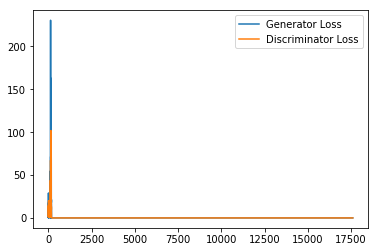

saved_fig


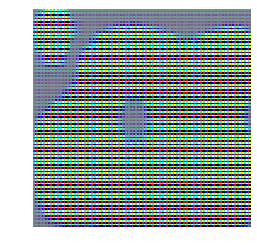

saved_fig


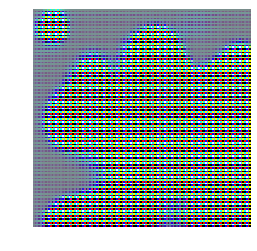

saved_fig


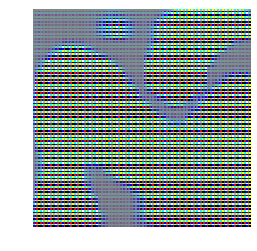

saved_fig


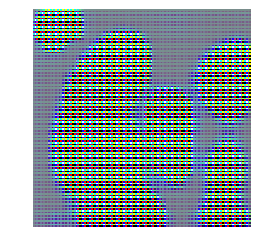

saved_fig


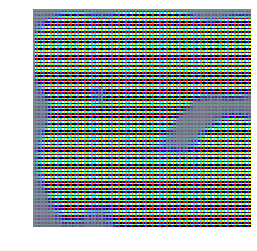

completed epoch 1 
 Time: 168.46173405647278
starting epoch 2
completed file 9. 1/11 completed
completed file 8. 2/11 completed
completed file 6. 3/11 completed
completed file 5. 4/11 completed
completed file 2. 5/11 completed
completed file 3. 6/11 completed
completed file 10. 7/11 completed
completed file 4. 8/11 completed
completed file 7. 9/11 completed
completed file 1. 10/11 completed
completed file 11. 11/11 completed
completed epoch 2 
 Time: 133.76767420768738
starting epoch 3
completed file 2. 1/11 completed
completed file 10. 2/11 completed
completed file 8. 3/11 completed
completed file 7. 4/11 completed
completed file 6. 5/11 completed
completed file 3. 6/11 completed
completed file 4. 7/11 completed
completed file 11. 8/11 completed
completed file 9. 9/11 completed
completed file 1. 10/11 completed
completed file 5. 11/11 completed
completed epoch 3 
 Time: 128.41906714439392
starting epoch 4
completed file 1. 1/11 completed
completed file 2. 2/11 completed
completed file

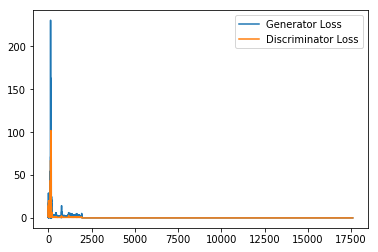

saved_fig


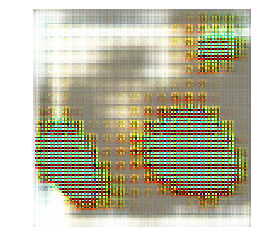

saved_fig


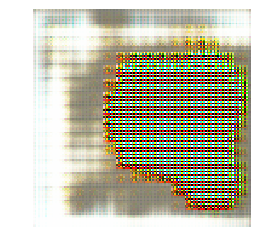

saved_fig


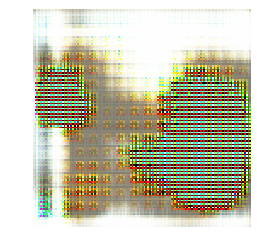

saved_fig


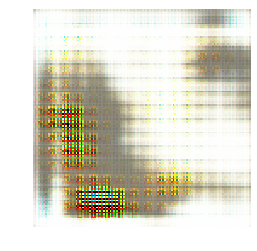

saved_fig


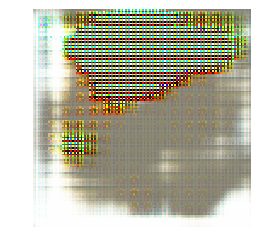

completed epoch 11 
 Time: 152.94054222106934
starting epoch 12
completed file 7. 1/11 completed
completed file 5. 2/11 completed
completed file 4. 3/11 completed
completed file 2. 4/11 completed
completed file 9. 5/11 completed
completed file 8. 6/11 completed
completed file 3. 7/11 completed
completed file 1. 8/11 completed
completed file 10. 9/11 completed
completed file 6. 10/11 completed
completed file 11. 11/11 completed
completed epoch 12 
 Time: 129.01389241218567
starting epoch 13
completed file 3. 1/11 completed
completed file 6. 2/11 completed
completed file 10. 3/11 completed
completed file 7. 4/11 completed
completed file 4. 5/11 completed
completed file 9. 6/11 completed
completed file 8. 7/11 completed
completed file 11. 8/11 completed
completed file 1. 9/11 completed
completed file 2. 10/11 completed
completed file 5. 11/11 completed
completed epoch 13 
 Time: 128.14101147651672
starting epoch 14
completed file 8. 1/11 completed
completed file 5. 2/11 completed
complete

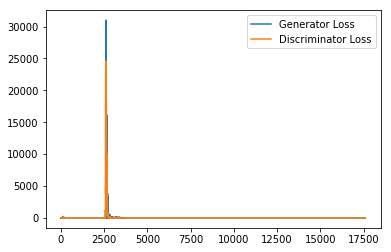

saved_fig


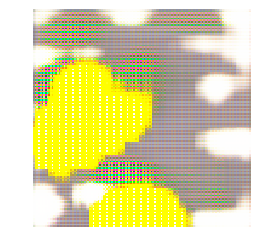

saved_fig


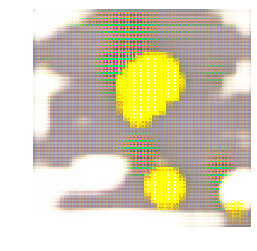

saved_fig


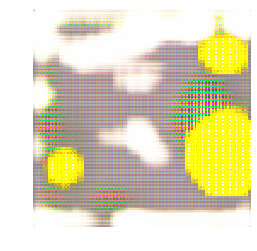

saved_fig


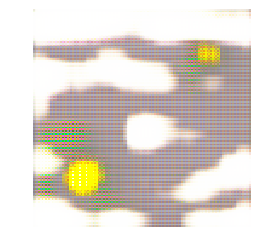

saved_fig


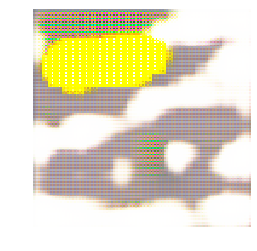

completed epoch 21 
 Time: 152.62887907028198
starting epoch 22
completed file 8. 1/11 completed
completed file 2. 2/11 completed
completed file 9. 3/11 completed
completed file 7. 4/11 completed
completed file 10. 5/11 completed
completed file 3. 6/11 completed
completed file 1. 7/11 completed
completed file 5. 8/11 completed
completed file 6. 9/11 completed
completed file 4. 10/11 completed
completed file 11. 11/11 completed
completed epoch 22 
 Time: 128.36764764785767
starting epoch 23
completed file 11. 1/11 completed
completed file 4. 2/11 completed
completed file 3. 3/11 completed
completed file 2. 4/11 completed
completed file 10. 5/11 completed
completed file 1. 6/11 completed
completed file 5. 7/11 completed
completed file 7. 8/11 completed
completed file 6. 9/11 completed
completed file 8. 10/11 completed
completed file 9. 11/11 completed
completed epoch 23 
 Time: 127.49628829956055
starting epoch 24
completed file 8. 1/11 completed
completed file 11. 2/11 completed
complet

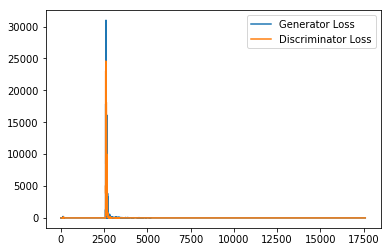

saved_fig


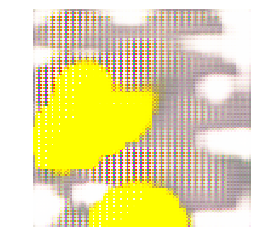

saved_fig


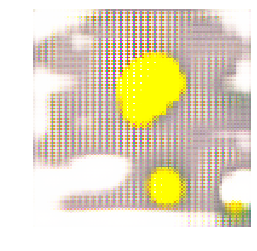

saved_fig


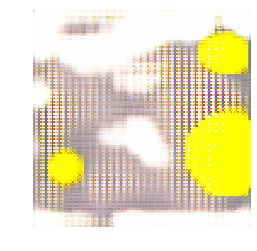

saved_fig


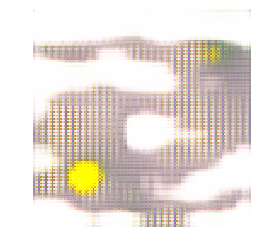

saved_fig


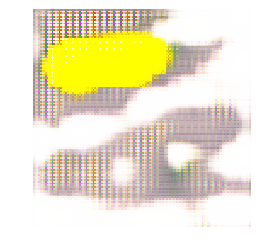

completed epoch 31 
 Time: 154.31425952911377
starting epoch 32
completed file 4. 1/11 completed
completed file 3. 2/11 completed
completed file 1. 3/11 completed
completed file 10. 4/11 completed
completed file 9. 5/11 completed
completed file 2. 6/11 completed
completed file 6. 7/11 completed
completed file 8. 8/11 completed
completed file 7. 9/11 completed
completed file 11. 10/11 completed
completed file 5. 11/11 completed
completed epoch 32 
 Time: 128.50436854362488
starting epoch 33
completed file 2. 1/11 completed
completed file 3. 2/11 completed
completed file 6. 3/11 completed
completed file 11. 4/11 completed
completed file 1. 5/11 completed
completed file 8. 6/11 completed
completed file 5. 7/11 completed
completed file 4. 8/11 completed
completed file 7. 9/11 completed
completed file 9. 10/11 completed
completed file 10. 11/11 completed
completed epoch 33 
 Time: 127.42300343513489
starting epoch 34
completed file 2. 1/11 completed
completed file 10. 2/11 completed
complet

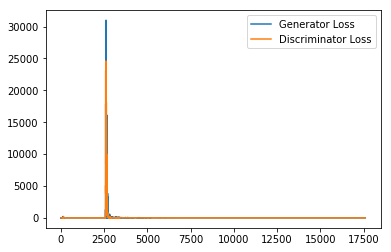

saved_fig


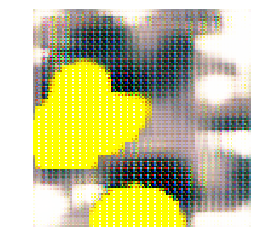

saved_fig


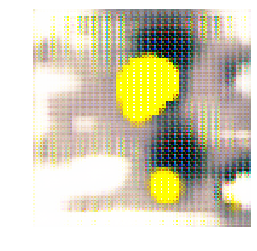

saved_fig


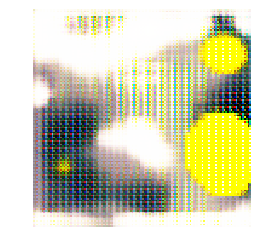

saved_fig


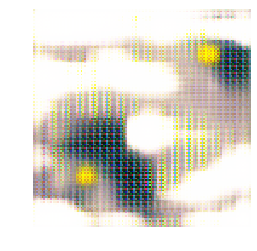

saved_fig


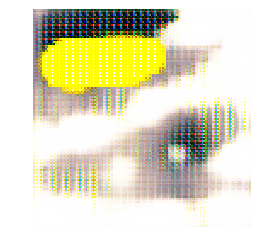

completed epoch 41 
 Time: 153.4381387233734
starting epoch 42
completed file 8. 1/11 completed
completed file 6. 2/11 completed
completed file 3. 3/11 completed
completed file 4. 4/11 completed
completed file 10. 5/11 completed
completed file 9. 6/11 completed
completed file 7. 7/11 completed
completed file 5. 8/11 completed
completed file 1. 9/11 completed
completed file 2. 10/11 completed
completed file 11. 11/11 completed
completed epoch 42 
 Time: 128.18958401679993
starting epoch 43
completed file 5. 1/11 completed
completed file 7. 2/11 completed
completed file 1. 3/11 completed
completed file 6. 4/11 completed
completed file 9. 5/11 completed
completed file 10. 6/11 completed
completed file 4. 7/11 completed
completed file 8. 8/11 completed
completed file 11. 9/11 completed
completed file 3. 10/11 completed
completed file 2. 11/11 completed
completed epoch 43 
 Time: 127.14006233215332
starting epoch 44
completed file 10. 1/11 completed
completed file 7. 2/11 completed
complete

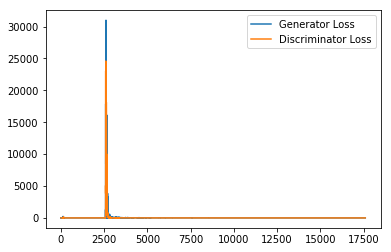

saved_fig


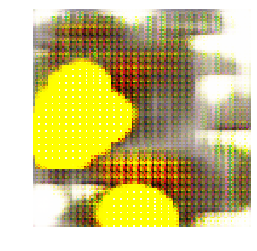

saved_fig


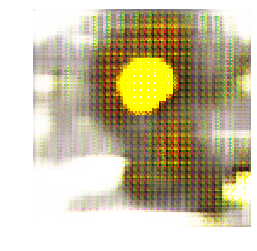

saved_fig


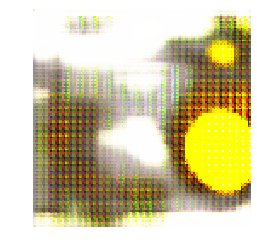

saved_fig


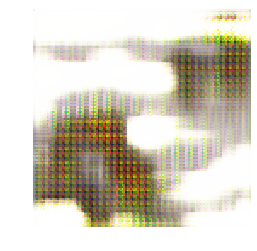

saved_fig


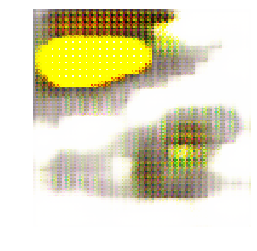

completed epoch 51 
 Time: 152.52172231674194
starting epoch 52
completed file 4. 1/11 completed
completed file 6. 2/11 completed
completed file 10. 3/11 completed
completed file 2. 4/11 completed
completed file 9. 5/11 completed
completed file 8. 6/11 completed
completed file 1. 7/11 completed
completed file 7. 8/11 completed
completed file 5. 9/11 completed
completed file 11. 10/11 completed
completed file 3. 11/11 completed
completed epoch 52 
 Time: 127.75868344306946
starting epoch 53
completed file 11. 1/11 completed
completed file 7. 2/11 completed
completed file 8. 3/11 completed
completed file 10. 4/11 completed
completed file 4. 5/11 completed
completed file 5. 6/11 completed
completed file 6. 7/11 completed
completed file 2. 8/11 completed
completed file 3. 9/11 completed
completed file 9. 10/11 completed
completed file 1. 11/11 completed
completed epoch 53 
 Time: 127.14972066879272
starting epoch 54
completed file 8. 1/11 completed
completed file 7. 2/11 completed
complete

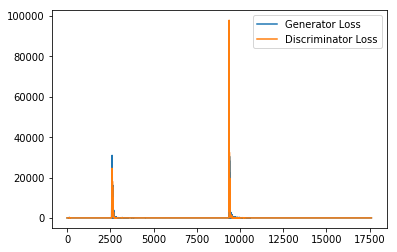

saved_fig


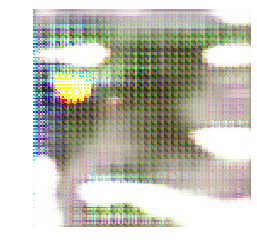

saved_fig


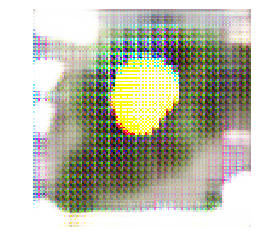

saved_fig


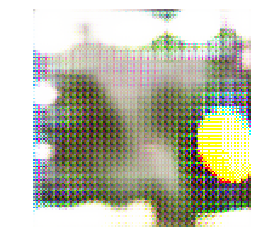

saved_fig


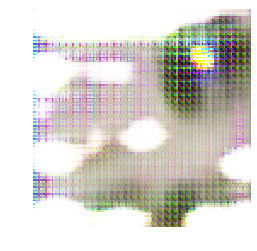

saved_fig


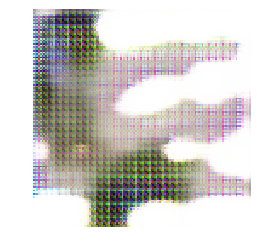

completed epoch 61 
 Time: 152.422429561615
starting epoch 62
completed file 4. 1/11 completed
completed file 1. 2/11 completed
completed file 6. 3/11 completed
completed file 7. 4/11 completed
completed file 3. 5/11 completed
completed file 10. 6/11 completed
completed file 8. 7/11 completed
completed file 2. 8/11 completed
completed file 9. 9/11 completed
completed file 11. 10/11 completed
completed file 5. 11/11 completed
completed epoch 62 
 Time: 128.23797154426575
starting epoch 63
completed file 5. 1/11 completed
completed file 11. 2/11 completed
completed file 1. 3/11 completed
completed file 4. 4/11 completed
completed file 2. 5/11 completed
completed file 7. 6/11 completed
completed file 8. 7/11 completed
completed file 6. 8/11 completed
completed file 9. 9/11 completed
completed file 10. 10/11 completed
completed file 3. 11/11 completed
completed epoch 63 
 Time: 127.18503737449646
starting epoch 64
completed file 9. 1/11 completed
completed file 2. 2/11 completed
completed 

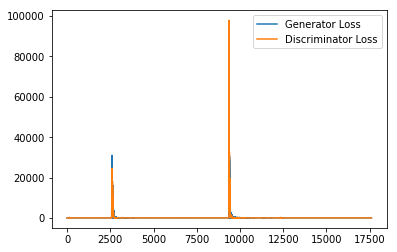

saved_fig


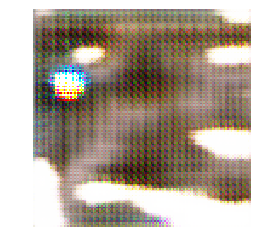

saved_fig


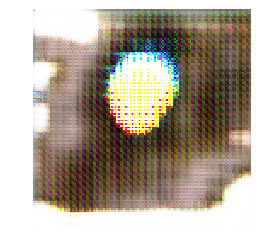

saved_fig


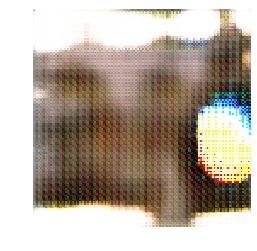

saved_fig


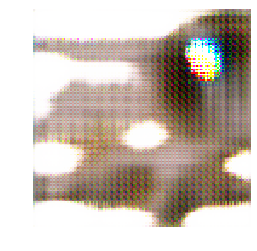

saved_fig


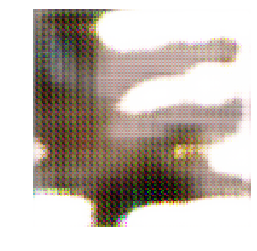

completed epoch 71 
 Time: 152.14464616775513
starting epoch 72
completed file 10. 1/11 completed
completed file 4. 2/11 completed
completed file 1. 3/11 completed
completed file 3. 4/11 completed
completed file 5. 5/11 completed
completed file 2. 6/11 completed
completed file 11. 7/11 completed
completed file 7. 8/11 completed
completed file 9. 9/11 completed
completed file 8. 10/11 completed
completed file 6. 11/11 completed
completed epoch 72 
 Time: 128.1728060245514
starting epoch 73
completed file 2. 1/11 completed
completed file 5. 2/11 completed
completed file 6. 3/11 completed
completed file 8. 4/11 completed
completed file 1. 5/11 completed
completed file 10. 6/11 completed
completed file 7. 7/11 completed
completed file 4. 8/11 completed
completed file 9. 9/11 completed
completed file 11. 10/11 completed
completed file 3. 11/11 completed
completed epoch 73 
 Time: 126.98749232292175
starting epoch 74
completed file 11. 1/11 completed
completed file 10. 2/11 completed
complet

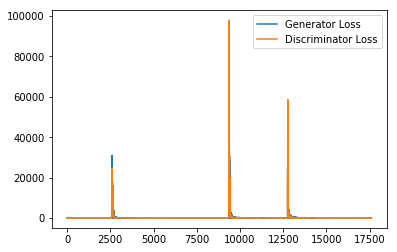

saved_fig


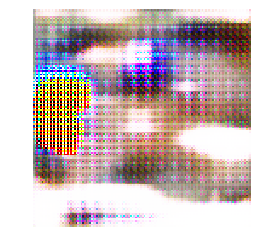

saved_fig


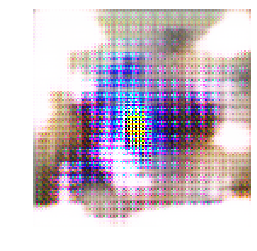

saved_fig


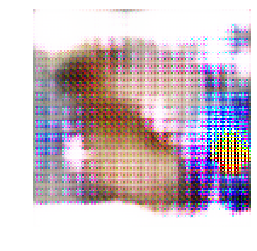

saved_fig


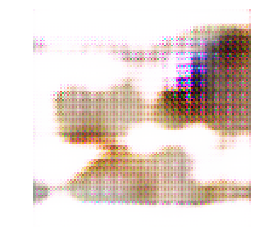

saved_fig


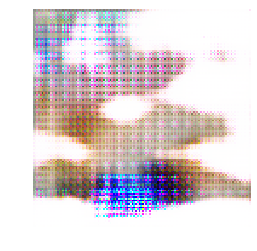

completed epoch 81 
 Time: 152.51461553573608
starting epoch 82
completed file 9. 1/11 completed
completed file 8. 2/11 completed
completed file 6. 3/11 completed
completed file 7. 4/11 completed
completed file 3. 5/11 completed
completed file 1. 6/11 completed
completed file 4. 7/11 completed
completed file 10. 8/11 completed
completed file 2. 9/11 completed
completed file 5. 10/11 completed
completed file 11. 11/11 completed
completed epoch 82 
 Time: 127.91834926605225
starting epoch 83
completed file 7. 1/11 completed
completed file 2. 2/11 completed
completed file 1. 3/11 completed
completed file 9. 4/11 completed
completed file 10. 5/11 completed
completed file 3. 6/11 completed
completed file 8. 7/11 completed
completed file 6. 8/11 completed
completed file 11. 9/11 completed
completed file 5. 10/11 completed
completed file 4. 11/11 completed
completed epoch 83 
 Time: 127.1688449382782
starting epoch 84
completed file 3. 1/11 completed
completed file 4. 2/11 completed
completed

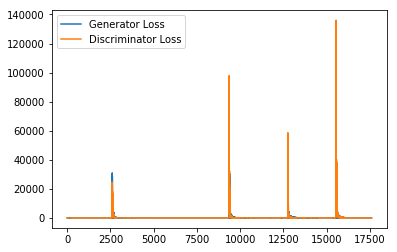

saved_fig


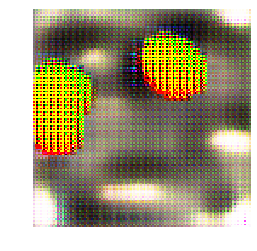

saved_fig


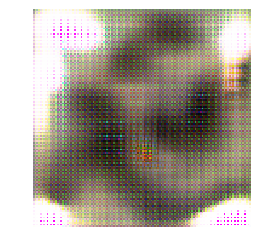

saved_fig


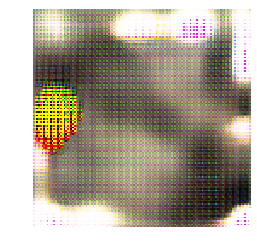

saved_fig


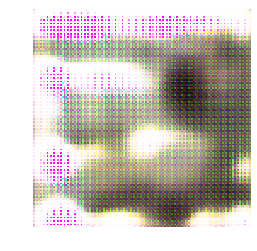

saved_fig


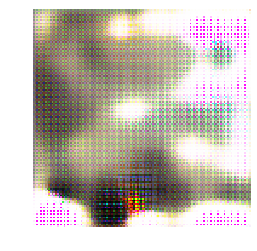

completed epoch 91 
 Time: 151.70677185058594
starting epoch 92
completed file 6. 1/11 completed
completed file 1. 2/11 completed
completed file 5. 3/11 completed
completed file 9. 4/11 completed
completed file 10. 5/11 completed
completed file 2. 6/11 completed
completed file 3. 7/11 completed
completed file 11. 8/11 completed
completed file 8. 9/11 completed
completed file 4. 10/11 completed
completed file 7. 11/11 completed
completed epoch 92 
 Time: 127.78313827514648
starting epoch 93
completed file 2. 1/11 completed
completed file 10. 2/11 completed
completed file 8. 3/11 completed
completed file 1. 4/11 completed
completed file 7. 5/11 completed
completed file 6. 6/11 completed
completed file 4. 7/11 completed
completed file 3. 8/11 completed
completed file 11. 9/11 completed
completed file 9. 10/11 completed
completed file 5. 11/11 completed
completed epoch 93 
 Time: 126.74182724952698
starting epoch 94
completed file 7. 1/11 completed
completed file 5. 2/11 completed
complete

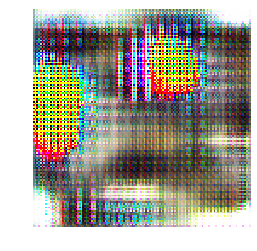

saved_fig


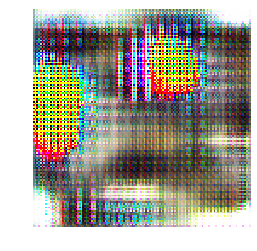

saved_fig


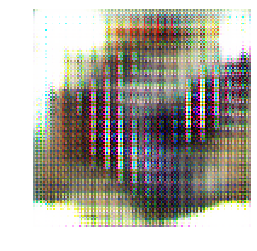

saved_fig


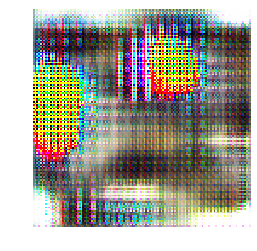

saved_fig


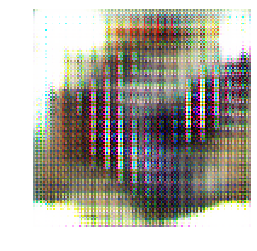

saved_fig


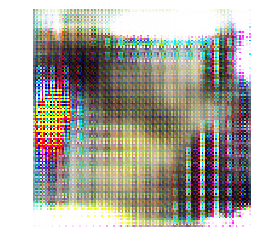

saved_fig


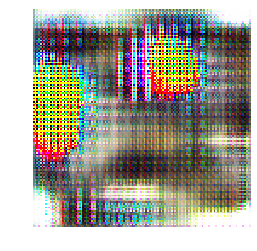

saved_fig


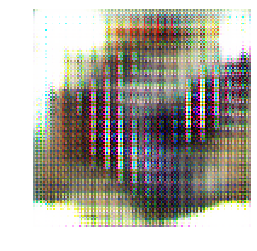

saved_fig


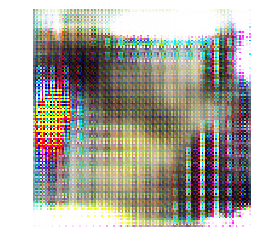

saved_fig


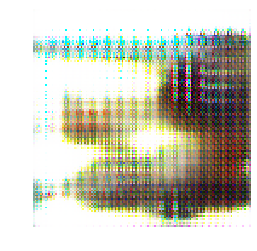

saved_fig


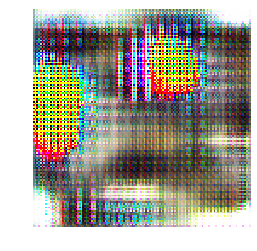

saved_fig


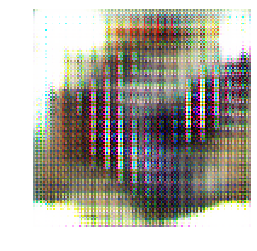

saved_fig


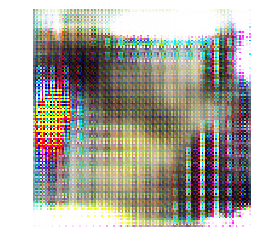

saved_fig


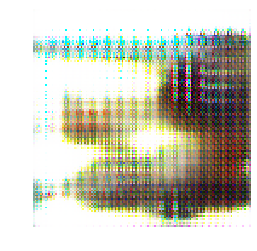

saved_fig


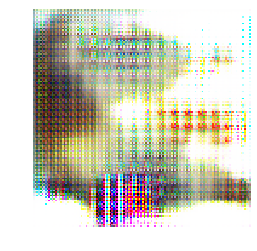

In [14]:
train()


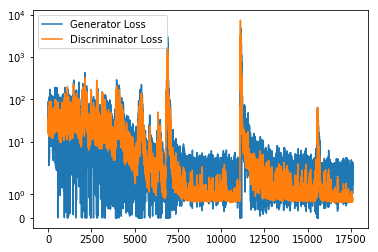

In [65]:
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")

plt.legend()
plt.yscale('symlog')
plt.savefig(image_save_path + "/Loss")
plt.show()
